In [58]:
import matplotlib.pyplot as plt
import pandas
import math
import numpy as np
import keras.callbacks
import sklearn.metrics as metrics
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers import LSTM,SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator

# Import function to plot the confussion matrix
import plotcm

In [59]:
#model_type = 'LSTM'
#model_type = 'GRU'
model_type = 'SIMPLE'
train = True 

data_path = "../DATA/BW-dogs-vs-cats/train/"
test_path = "../DATA/BW-dogs-vs-cats/test/"

learning_rate = 0.001
training_steps = 10000
batch_size = 64
shape_size = 200
num_hidden = 128
display_step = shape_size

experiment_rootdir = './RNN-results/'
weights_path = experiment_rootdir + model_type + "_weights.h5"
accuracy_img_name = experiment_rootdir + model_type + '_accuracy-loss.png'
cm_dir = experiment_rootdir + model_type + '_'

# Output dimension (number of sublects in our problem)
num_classes = 2
# Name of each gesture of the database
CLASSES = ['cat', 'dog']

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

In [60]:
"""
count=0
for f_name in os.listdir(path_subjects):
    if(count<20):
        img = Image.open(path_subjects + '/' + f_name)
        plt.imshow(img, vmin=0, vmax=255)
        plt.title('subject: ' + str(f_name))
        plt.show()
        count+=1
"""

"\ncount=0\nfor f_name in os.listdir(path_subjects):\n    if(count<20):\n        img = Image.open(path_subjects + '/' + f_name)\n        plt.imshow(img, vmin=0, vmax=255)\n        plt.title('subject: ' + str(f_name))\n        plt.show()\n        count+=1\n"

In [61]:
# prepare iterators
datagen = ImageDataGenerator(rescale=1.0/255.0)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

train_it = datagen.flow_from_directory(data_path, class_mode='binary', color_mode = 'grayscale', batch_size=batch_size, target_size=(shape_size, shape_size))
test_it = datagen.flow_from_directory(test_path, class_mode='binary', color_mode = 'grayscale', batch_size=batch_size, target_size=(shape_size, shape_size))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [62]:
def LSTM_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(LSTM(4))
    model.add(Dense(2, activation='softmax'))

    return model
    
def GRU_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(GRU(4,return_sequences=False))
    model.add(Dense(2, activation='softmax'))

    return model

def SIMPLE_Model():
    # create and fit the LSTM network
    model = Sequential()
    model.add(Reshape((200, 200), input_shape=(200, 200,1)))
    model.add(SimpleRNN(128))
    model.add(Dense(2, activation='softmax'))

    return model


In [63]:

if model_type == 'LSTM':
    model = LSTM_Model()
elif model_type == 'GRU':
    model = GRU_Model()
elif model_type == 'SIMPLE':
    model = SIMPLE_Model()

model.compile(metrics=['accuracy'], loss='sparse_categorical_crossentropy', optimizer='adam')

if train == True:
    if  os.path.exists(weights_path):
        os.remove(weights_path)
    STEPS_PER_EPOCH_TRAIN = train_it.n//batch_size
    cb_checkpointer = keras.callbacks.ModelCheckpoint(filepath = weights_path, monitor = 'accuracy', save_best_only = True, mode = 'auto')
    fit_history = model.fit_generator(generator=train_it, epochs=10, steps_per_epoch=STEPS_PER_EPOCH_TRAIN, callbacks=[cb_checkpointer])
else:
    if weights_path:
        try:
            model.load_weights(weights_path)
            print("Loaded model from {}".format(weights_path))
        except:
            print("Impossible to find weight path. Returning untrained model")
    

Epoch 1/10
312/312 [==============================] - 42s 135ms/step - loss: 0.6920 - accuracy: 0.5468
Epoch 2/10
312/312 [==============================] - 39s 124ms/step - loss: 0.6849 - accuracy: 0.5607
Epoch 3/10
312/312 [==============================] - 39s 124ms/step - loss: 0.6807 - accuracy: 0.5684
Epoch 4/10
312/312 [==============================] - 39s 123ms/step - loss: 0.6763 - accuracy: 0.5745
Epoch 5/10
312/312 [==============================] - 41s 131ms/step - loss: 0.6738 - accuracy: 0.5824
Epoch 6/10
312/312 [==============================] - 46s 146ms/step - loss: 0.6771 - accuracy: 0.5745
Epoch 7/10
312/312 [==============================] - 46s 146ms/step - loss: 0.6741 - accuracy: 0.5797
Epoch 8/10
312/312 [==============================] - 47s 149ms/step - loss: 0.6698 - accuracy: 0.5858
Epoch 9/10
312/312 [==============================] - 47s 151ms/step - loss: 0.6689 - accuracy: 0.5882
Epoch 10/10
312/312 [==============================] - 46s 148ms/step - l

(5000,)
-----------------------------------------------
Evaluation:
Average accuracy = 0.5078
-----------------------------------------------


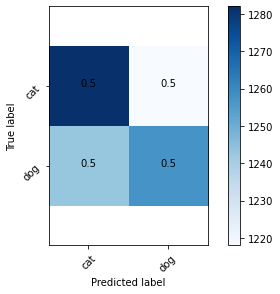

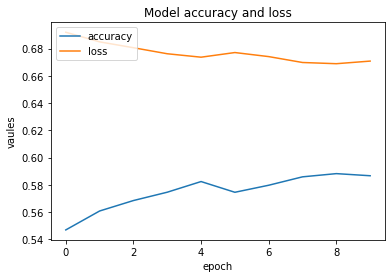

In [64]:
# Get predictions using predict_generator function
STEPS_PER_EPOCH_TEST = test_it.n//batch_size +1
pred_labels = model.predict_generator(test_it,steps = STEPS_PER_EPOCH_TEST)
pred_labels = np.argmax(pred_labels, axis = 1)

# Select the class which has the higher predicted value
print(pred_labels.shape)

# Create groundtruth
gt = np.zeros(pred_labels.shape)
init_index = 0
end_index = 0
user_id = 0
for users in sorted(os.listdir(test_path)):
    user_id = user_id + 1
    if os.path.isdir(os.path.join(test_path, users)):
        user_path = os.path.join(test_path, users)
        for root, _, files in sorted(os.walk(user_path)):
            num_images_user = len(files)
            end_index = init_index + num_images_user
            gt[init_index:end_index] = user_id - 1
            init_index = end_index
            
# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, pred_labels)
print('Average accuracy = ' + str(ave_accuracy))
print("-----------------------------------------------")

# Visualize confusion matrix
plotcm.plotcm(path_to_results=cm_dir, real_labels= gt, pred_labels = pred_labels,classes =CLASSES, experiment_rootdir = experiment_rootdir, normalize=True)

if train == True:
    plt.plot(fit_history.history['accuracy'])
    plt.plot(fit_history.history['loss'])
    plt.title('Model accuracy and loss')
    plt.ylabel('vaules')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    # Save the figure
    plt.savefig(accuracy_img_name)
    # Show figure
    plt.show()

